## INTRODUCTION TO DEEP LEARNING ON GEOSPATIAL DATA

### READING TIF FILES

In [1]:
import rasterio
import os
import numpy as np
DATADIR = 'data/'

In [36]:
# READING THE DATA
with rasterio.open(os.path.join(DATADIR, 'geo/cph_ama.tif')) as src:
    raster_data = src.read()
    raster_metadata = src.meta.copy()

In [37]:
raster_data.shape

(1, 64000, 80000)

In [5]:
raster_metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4e+38,
 'width': 500,
 'height': 500,
 'count': 6,
 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'),
 'transform': Affine(2.0, 0.0, 3217732.570707773,
        0.0, -2.0, 3127010.943205277)}

In [12]:
# READING THE MASK
#with rasterio.open(os.path.join(DATADIR, 'geo/cph_ama.tif')) as src:
#    mask_data = src.dataset_mask()
#    mask_metadata = src.meta.copy()

AttributeError: 'numpy.ndarray' object has no attribute 'meta'

In [ ]:
# mask_metadata.shape

In [8]:
# mask_metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4e+38,
 'width': 500,
 'height': 500,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'),
 'transform': Affine(2.0, 0.0, 3217732.570636626,
        0.0, -2.0, 3127010.942872643)}

### MERGING BAND FILES

In [35]:
import glob
import numpy as np

# we need one profile as template to write the merged_bands
profile_template = None
count = 0
# reading all band files and stack them together in a numpy array
for file in glob.glob(f'{DATADIR}geo/*.tif'):
    with rasterio.open(file) as src:
        if not profile_template:
            profile_template = src.profile.copy()
            merged = src.read()
        else:
            data = src.read()
            print(data.shape,merged.shape)
            merged = np.concatenate((merged, data), axis=0)
        count+=1

(1, 80000, 80000) (1, 48000, 80000)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 48000 and the array at index 1 has size 80000

In [ ]:
merged.shape

In [ ]:
profile_template

In [42]:
# Updating the profile to write the merged product
profile_template.update({'count': count,
                         'dtype': 'float32'}
                       )

# writing the merged product
with rasterio.open('data/merged/A_UK_S_merged.tif', 'w', **profile_template) as dst:
    dst.write(merged)

### CREATING VALIDATION DATA

In [43]:
# One way of creating the data is to randomnly select patches or pixels from a raster
# but when it comes to geospatial data, it is usually good to select a part of the image
# because with random patches/pixels you might ending up picking validation data very similar
# to the training data.

## Spliting the images in two parts
from rasterio.windows import Window

TRAIN_WINDOW = Window(0, 0, 500, 400)
VAL_WINDOW = Window(0, 400, 500, 100)

#read and split the image
with rasterio.open(os.path.join(DATADIR, 'merged/A_UK_S_merged.tif')) as src:
    train_data = src.read(window=TRAIN_WINDOW)
    val_data = src.read(window=VAL_WINDOW)
    data_profile = src.profile.copy()

#write training data
train_profile = data_profile.copy()
train_profile.update({'height': TRAIN_WINDOW.height,
                      'width': TRAIN_WINDOW.width,
                      'transform': rasterio.windows.transform(TRAIN_WINDOW, data_profile['transform'])
                     }
                    )

with rasterio.open(os.path.join(DATADIR, 'train_val/UK_train.tif'), 'w', **train_profile) as dst:
    dst.write(train_data)

#write test data
val_profile = data_profile.copy()
val_profile.update({'height': VAL_WINDOW.height,
                    'width': VAL_WINDOW.width,
                    'transform': rasterio.windows.transform(VAL_WINDOW, data_profile['transform'])
                   }
                  )
with rasterio.open(os.path.join(DATADIR, 'train_val/UK_val.tif'), 'w', **val_profile) as dst:
    dst.write(val_data)
    
#read and split the mask
with rasterio.open(os.path.join(DATADIR, 'merged/SWF.tif')) as src:
    train_mask = src.read(window=TRAIN_WINDOW)
    val_mask = src.read(window=VAL_WINDOW)
    mask_profile = src.profile.copy()

#write training mask
train_mask_profile = mask_profile.copy()
train_mask_profile.update({'height': TRAIN_WINDOW.height,
                           'width': TRAIN_WINDOW.width,
                           'transform': rasterio.windows.transform(TRAIN_WINDOW, mask_profile['transform'])
                     }
                    )

with rasterio.open(os.path.join(DATADIR, 'train_val/UK_train_mask.tif'), 'w', **train_mask_profile) as dst:
    dst.write(train_mask)

#write test data
val_mask_profile = mask_profile.copy()
val_mask_profile.update({'height': VAL_WINDOW.height,
                         'width': VAL_WINDOW.width,
                         'transform': rasterio.windows.transform(VAL_WINDOW, mask_profile['transform'])
                   }
                  )
with rasterio.open(os.path.join(DATADIR, 'train_val/UK_val_mask.tif'), 'w', **val_mask_profile) as dst:
    dst.write(val_mask)

### CREATING PATCHES

In [44]:
from rasterio import windows
from itertools import product

def get_tiles(ds, width=224, height=224):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width//2), range(0, nrows, height//2))  ## Control the level of overlap
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in offsets:
        window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

In [45]:
in_path = os.path.join(DATADIR, 'train_val')
out_path = os.path.join(DATADIR, 'train_patches')
input_filenames = [('UK_train.tif', 'UK_train_mask.tif')]

output_filename = 'tile_{}-{}.tif'
output_lab_filename = 'tile_labels_{}-{}.tif'

for filename in input_filenames:
    (input_filename, label_filename) = filename
    with rasterio.open(os.path.join(in_path, input_filename)) as inds:
        tile_width, tile_height = 64, 64
        meta = inds.meta.copy()
        nodata = meta['nodata']
    
        with rasterio.open(os.path.join(in_path, label_filename)) as labs:
            meta_labels = labs.meta.copy()
            labs_data = labs.read()
            labs_num = len(np.unique(labs_data))
            name_counter = 0
            for window, transform in get_tiles(inds, tile_width, tile_height):
                
                meta['transform'] = transform
                meta['width'], meta['height'] = window.width, window.height
                meta_labels['transform'] = transform
                meta_labels['width'], meta_labels['height'] = window.width, window.height
                data = inds.read(window=window)
                labels = labs.read(window=window)
                #if labs_num == 5:
                #    print("found 5 labs in :  " + label_filename)
                #    labels[labels == 5] = 6
                if window.width ==  tile_width and window.height == tile_height: #and not np.all(data[5, :, :] == nodata):
                    outpath = os.path.join(out_path, output_filename.format(input_filename[:2], name_counter))
                    outpath_lab = os.path.join(out_path, output_lab_filename.format(input_filename[:2], name_counter))
                    with rasterio.open(outpath, 'w', **meta) as outds:
                        outds.write(data)
                    with rasterio.open(outpath_lab, 'w', **meta_labels) as outls:
                        outls.write(labels)
                    name_counter += 1

In [46]:
### Follow the same procedure to create patches for validation ###

in_path = os.path.join(DATADIR, 'train_val')
out_path = os.path.join(DATADIR, 'val_patches')
input_filenames = [('UK_val.tif', 'UK_val_mask.tif')]

output_filename = 'tile_{}-{}.tif'
output_lab_filename = 'tile_labels_{}-{}.tif'

for filename in input_filenames:
    (input_filename, label_filename) = filename
    with rasterio.open(os.path.join(in_path, input_filename)) as inds:
        tile_width, tile_height = 64, 64
        meta = inds.meta.copy()
        nodata = meta['nodata']
    
        with rasterio.open(os.path.join(in_path, label_filename)) as labs:
            meta_labels = labs.meta.copy()
            labs_data = labs.read()
            labs_num = len(np.unique(labs_data))
            name_counter = 0
            for window, transform in get_tiles(inds, tile_width, tile_height):
                
                meta['transform'] = transform
                meta['width'], meta['height'] = window.width, window.height
                meta_labels['transform'] = transform
                meta_labels['width'], meta_labels['height'] = window.width, window.height
                data = inds.read(window=window)
                labels = labs.read(window=window)
                #if labs_num == 5:
                #    print("found 5 labs in :  " + label_filename)
                #    labels[labels == 5] = 6
                if window.width ==  tile_width and window.height == tile_height: #and not np.all(data[5, :, :] == nodata):
                    outpath = os.path.join(out_path, output_filename.format(input_filename[:2], name_counter))
                    outpath_lab = os.path.join(out_path, output_lab_filename.format(input_filename[:2], name_counter))
                    with rasterio.open(outpath, 'w', **meta) as outds:
                        outds.write(data)
                    with rasterio.open(outpath_lab, 'w', **meta_labels) as outls:
                        outls.write(labels)
                    name_counter += 1

### Reading the data

In [47]:
## reading training data and labels
import glob
patch_path = os.path.join(DATADIR, 'train_patches/')

X_train = np.empty((154, 64, 64, 6), dtype=np.float32)
y_train = np.empty((154, 64, 64), dtype=np.int8)

for index, filename in enumerate(sorted(glob.glob(f'{patch_path}tile_UK*.tif'))):
    print(filename)
    print(index)
    with rasterio.open(filename, 'r') as src:
        data = src.read()
        profile = src.profile
    nodata = profile['nodata']
    data = np.swapaxes(data, 0, 1)
    data = np.swapaxes(data, 1, 2)
    X_train[index, :, :, :] = data

for index,filename in enumerate(sorted(glob.glob(f'{patch_path}tile_labels_UK*.tif'))):
        print(filename)
        print(index)
        with rasterio.open(filename, 'r') as src:
            labels = src.read()
            labels = labels.astype(np.int8)
        y_train[index, :, :] = labels[0, :, :]




data/train_patches/tile_UK-0.tif
0
data/train_patches/tile_UK-1.tif
1
data/train_patches/tile_UK-10.tif
2
data/train_patches/tile_UK-100.tif
3
data/train_patches/tile_UK-101.tif
4
data/train_patches/tile_UK-102.tif
5
data/train_patches/tile_UK-103.tif
6
data/train_patches/tile_UK-104.tif
7
data/train_patches/tile_UK-105.tif
8
data/train_patches/tile_UK-106.tif
9
data/train_patches/tile_UK-107.tif
10
data/train_patches/tile_UK-108.tif
11
data/train_patches/tile_UK-109.tif
12
data/train_patches/tile_UK-11.tif
13
data/train_patches/tile_UK-110.tif
14
data/train_patches/tile_UK-111.tif
15
data/train_patches/tile_UK-112.tif
16
data/train_patches/tile_UK-113.tif
17
data/train_patches/tile_UK-114.tif
18
data/train_patches/tile_UK-115.tif
19
data/train_patches/tile_UK-116.tif
20
data/train_patches/tile_UK-117.tif
21
data/train_patches/tile_UK-118.tif
22
data/train_patches/tile_UK-119.tif
23
data/train_patches/tile_UK-12.tif
24
data/train_patches/tile_UK-120.tif
25
data/train_patches/tile_UK-12

data/train_patches/tile_labels_UK-83.tif
136
data/train_patches/tile_labels_UK-84.tif
137
data/train_patches/tile_labels_UK-85.tif
138
data/train_patches/tile_labels_UK-86.tif
139
data/train_patches/tile_labels_UK-87.tif
140
data/train_patches/tile_labels_UK-88.tif
141
data/train_patches/tile_labels_UK-89.tif
142
data/train_patches/tile_labels_UK-9.tif
143
data/train_patches/tile_labels_UK-90.tif
144
data/train_patches/tile_labels_UK-91.tif
145
data/train_patches/tile_labels_UK-92.tif
146
data/train_patches/tile_labels_UK-93.tif
147
data/train_patches/tile_labels_UK-94.tif
148
data/train_patches/tile_labels_UK-95.tif
149
data/train_patches/tile_labels_UK-96.tif
150
data/train_patches/tile_labels_UK-97.tif
151
data/train_patches/tile_labels_UK-98.tif
152
data/train_patches/tile_labels_UK-99.tif
153


In [48]:
## reading validation data and labels
import glob
patch_path = os.path.join(DATADIR, 'val_patches/')

X_val = np.empty((28, 64, 64, 6), dtype=np.float32)
y_val = np.empty((28, 64, 64), dtype=np.int8)

for index, filename in enumerate(sorted(glob.glob(f'{patch_path}tile_UK*.tif'))):
    print(filename)
    print(index)
    with rasterio.open(filename, 'r') as src:
        data = src.read()
        profile = src.profile
    nodata = profile['nodata']
    data = np.swapaxes(data, 0, 1)
    data = np.swapaxes(data, 1, 2)
    X_val[index, :, :, :] = data

for index,filename in enumerate(sorted(glob.glob(f'{patch_path}tile_labels_UK*.tif'))):
        print(filename)
        print(index)
        with rasterio.open(filename, 'r') as src:
            labels = src.read()
            labels = labels.astype(np.int8)
        y_val[index, :, :] = labels[0, :, :]

data/val_patches/tile_UK-0.tif
0
data/val_patches/tile_UK-1.tif
1
data/val_patches/tile_UK-10.tif
2
data/val_patches/tile_UK-11.tif
3
data/val_patches/tile_UK-12.tif
4
data/val_patches/tile_UK-13.tif
5
data/val_patches/tile_UK-14.tif
6
data/val_patches/tile_UK-15.tif
7
data/val_patches/tile_UK-16.tif
8
data/val_patches/tile_UK-17.tif
9
data/val_patches/tile_UK-18.tif
10
data/val_patches/tile_UK-19.tif
11
data/val_patches/tile_UK-2.tif
12
data/val_patches/tile_UK-20.tif
13
data/val_patches/tile_UK-21.tif
14
data/val_patches/tile_UK-22.tif
15
data/val_patches/tile_UK-23.tif
16
data/val_patches/tile_UK-24.tif
17
data/val_patches/tile_UK-25.tif
18
data/val_patches/tile_UK-26.tif
19
data/val_patches/tile_UK-27.tif
20
data/val_patches/tile_UK-3.tif
21
data/val_patches/tile_UK-4.tif
22
data/val_patches/tile_UK-5.tif
23
data/val_patches/tile_UK-6.tif
24
data/val_patches/tile_UK-7.tif
25
data/val_patches/tile_UK-8.tif
26
data/val_patches/tile_UK-9.tif
27
data/val_patches/tile_labels_UK-0.tif
0


In [49]:
y_train.shape

(154, 64, 64)

In [50]:
#normalize input
for band in range(X_train.shape[3]):
    minX = np.min(X_train[:,:,:,band])
    maxX =np.max(X_train[:,:,:,band])
    X_train[:,:,:,band] = (X_train[:,:,:,band] - minX) / (maxX - minX)
    X_val[:,:,:,band]= (X_val[:,:,:,band] - minX) / (maxX - minX)

### Training model

In [51]:
import segmentation_models as sm
from segmentation_models import Unet
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
import tensorflow as tf

In [52]:
y_val = y_val.reshape((28, 64, 64, 1))

In [53]:
y_train = y_train.reshape((154, 64, 64, 1))

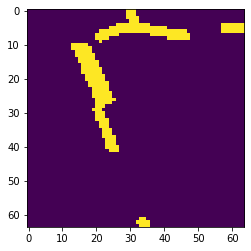

In [54]:
from matplotlib.pyplot import imshow
imshow(y_val[10,:,:,0])

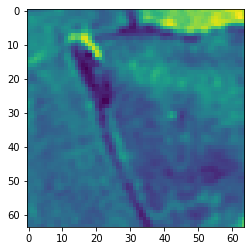

In [55]:
imshow(X_val[10,:,:,5])

In [56]:
## sequence to load data and apply augmentation
from keras.utils import Sequence

class UnetSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        data_index_min = int(idx*self.batch_size)
        data_index_max = int(min((idx+1)*self.batch_size, len(self.x)))
        
        indexes = self.x[data_index_min:data_index_max]
        this_batch_size = len(indexes)
        
        X = np.empty((this_batch_size, 64, 64, 6), dtype=np.float32)
        y = np.empty((this_batch_size, 64, 64, 1), dtype=np.uint8)
        
        for i, sample_index in enumerate(indexes):
            x_sample = self.x[idx, :, :, :]
            y_sample =self.y[idx,:,:]
            if self.augment is not None:
                augmented = self.augment(image=x_sample, mask=y_sample)
                image_augm = augmented['image']
                mask_augm = augmented['mask']
                X[i, :, :, :] = image_augm
                y[i, :, :, :] = mask_augm
            else:
                X[i, :, :, :] = x_sample
                y[i, :, :, :] = y_sample
        return X, y

In [57]:
## augmentation
from albumentations import (Compose, RandomCrop, HorizontalFlip, VerticalFlip, RandomRotate90, Transpose,
                           ShiftScaleRotate, RandomBrightnessContrast, RandomGamma, IAAEmboss, Blur, OneOf,
                           ElasticTransform, GridDistortion, OpticalDistortion, ToFloat)


train_augm = Compose([
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                RandomRotate90(p=0.5),
                Transpose(p=0.5),
                ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
                RandomBrightnessContrast(p=0.5),
                ], p = 1)

In [58]:
from segmentation_models import Unet
from keras.layers import Input, Conv2D
from keras.models import Model
base_model = Unet(backbone_name='efficientnetb0', encoder_weights='imagenet', encoder_freeze=True)
inp = Input(shape=(None, None, 6))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)
model = Model(inp, out, name=base_model.name)

In [59]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
# model autosave callbacks
mode_autosave = ModelCheckpoint("./weights/unet.h5", 
                                monitor='val_iou_score', 
                                mode='max', save_best_only=True, verbose=1, period=1)

tensorboard = TensorBoard(log_dir='./logs/tenboard', histogram_freq=0,
                          write_graph=True, write_images=False)

callbacks = [lr_reducer, tensorboard, mode_autosave]

In [60]:
from segmentation_models.losses import jaccard_loss
from segmentation_models.metrics import iou_score
from keras.optimizers import Adam
lre=0.001
adam = Adam(lr=lre)
model.compile(adam, jaccard_loss, ['binary_accuracy', iou_score])

In [61]:
train_gen = UnetSequence(X_train, y_train, 8, augmentations=train_augm)
test_gen = UnetSequence(X_val, y_val, 8, augmentations=None)

In [62]:
from segmentation_models.utils import set_trainable
print(model.summary())
model.fit(X_train, y_train, epochs=2, batch_size=8, validation_data=(X_val, y_val))
set_trainable(model)
model.fit_generator(train_gen, validation_data=test_gen, steps_per_epoch=len(X_train) // 8, validation_steps=len(X_val) // 8, epochs=100, callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 6)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     21        
_________________________________________________________________
model_4 (Model)              (None, None, None, 1)     10115501  
Total params: 10,115,522
Trainable params: 6,105,990
Non-trainable params: 4,009,532
_________________________________________________________________
None
Train on 154 samples, validate on 28 samples
Epoch 1/2
154/154 [==============================] - 22s 142ms/step - loss: 0.8951 - binary_accuracy: 0.6304 - iou_score: 0.1049 - val_loss: 0.8410 - val_binary_accuracy: 0.7544 - val_iou_score: 0.1590
Epoch 2/2
154/154 [==============================] - 2s 13ms/step - loss: 0.8174 - binary_accuracy: 0.8390 - iou_score: 0.1826 - val_lo

19/19 [==============================] - 2s 101ms/step - loss: 0.4412 - binary_accuracy: 0.9772 - iou_score: 0.5588 - val_loss: 0.7746 - val_binary_accuracy: 0.9499 - val_iou_score: 0.2254

Epoch 00027: val_iou_score did not improve from 0.35156
Epoch 28/100
19/19 [==============================] - 2s 101ms/step - loss: 0.4006 - binary_accuracy: 0.9816 - iou_score: 0.5994 - val_loss: 0.7261 - val_binary_accuracy: 0.9294 - val_iou_score: 0.2739

Epoch 00028: val_iou_score did not improve from 0.35156
Epoch 29/100
19/19 [==============================] - 2s 101ms/step - loss: 0.4448 - binary_accuracy: 0.9749 - iou_score: 0.5552 - val_loss: 0.8155 - val_binary_accuracy: 0.9509 - val_iou_score: 0.1845

Epoch 00029: val_iou_score did not improve from 0.35156
Epoch 30/100
19/19 [==============================] - 2s 100ms/step - loss: 0.4347 - binary_accuracy: 0.9776 - iou_score: 0.5653 - val_loss: 0.8760 - val_binary_accuracy: 0.9580 - val_iou_score: 0.1240

Epoch 00030: val_iou_score did no

19/19 [==============================] - 2s 104ms/step - loss: 0.4230 - binary_accuracy: 0.9782 - iou_score: 0.5770 - val_loss: 0.8732 - val_binary_accuracy: 0.9566 - val_iou_score: 0.1268

Epoch 00058: val_iou_score did not improve from 0.35156
Epoch 59/100
19/19 [==============================] - 2s 105ms/step - loss: 0.3683 - binary_accuracy: 0.9833 - iou_score: 0.6317 - val_loss: 0.7482 - val_binary_accuracy: 0.9497 - val_iou_score: 0.2518

Epoch 00059: val_iou_score did not improve from 0.35156
Epoch 60/100
19/19 [==============================] - 2s 101ms/step - loss: 0.4149 - binary_accuracy: 0.9804 - iou_score: 0.5851 - val_loss: 0.6951 - val_binary_accuracy: 0.9312 - val_iou_score: 0.3049

Epoch 00060: val_iou_score did not improve from 0.35156
Epoch 61/100
19/19 [==============================] - 2s 100ms/step - loss: 0.3784 - binary_accuracy: 0.9814 - iou_score: 0.6216 - val_loss: 0.8137 - val_binary_accuracy: 0.9491 - val_iou_score: 0.1863

Epoch 00061: val_iou_score did no

19/19 [==============================] - 2s 100ms/step - loss: 0.3213 - binary_accuracy: 0.9847 - iou_score: 0.6787 - val_loss: 0.8108 - val_binary_accuracy: 0.9491 - val_iou_score: 0.1892

Epoch 00089: val_iou_score did not improve from 0.35156
Epoch 90/100
19/19 [==============================] - 2s 101ms/step - loss: 0.4131 - binary_accuracy: 0.9806 - iou_score: 0.5869 - val_loss: 0.8653 - val_binary_accuracy: 0.9568 - val_iou_score: 0.1347

Epoch 00090: val_iou_score did not improve from 0.35156
Epoch 91/100
19/19 [==============================] - 2s 104ms/step - loss: 0.3226 - binary_accuracy: 0.9818 - iou_score: 0.6774 - val_loss: 0.7430 - val_binary_accuracy: 0.9507 - val_iou_score: 0.2570

Epoch 00091: val_iou_score did not improve from 0.35156
Epoch 92/100
19/19 [==============================] - 2s 102ms/step - loss: 0.4128 - binary_accuracy: 0.9811 - iou_score: 0.5872 - val_loss: 0.6908 - val_binary_accuracy: 0.9313 - val_iou_score: 0.3092

Epoch 00092: val_iou_score did no

In [63]:
model.load_weights("./weights/unet.h5")
y_pred = model.predict(X_val)

array([[1.8043667e-02, 1.2984276e-03, 2.6613176e-03, ..., 8.1238151e-04,
        6.4942241e-04, 5.1854551e-03],
       [1.6087294e-03, 1.2654066e-04, 5.6669116e-04, ..., 7.9303980e-05,
        4.7624111e-05, 6.5088272e-04],
       [2.3609698e-03, 3.0767918e-04, 1.1753738e-03, ..., 3.5047531e-05,
        1.8417835e-05, 3.1220913e-04],
       ...,
       [2.6935339e-04, 2.1457672e-06, 6.8545341e-07, ..., 2.0861626e-06,
        8.6426735e-07, 1.9973516e-04],
       [8.7007880e-04, 3.6060810e-05, 1.1175871e-05, ..., 1.5407801e-05,
        6.5565109e-06, 7.0384145e-04],
       [5.8412850e-03, 8.4036589e-04, 4.0712953e-04, ..., 3.7708879e-04,
        1.4588237e-04, 7.0360899e-03]], dtype=float32)

In [64]:
def iou_metric(y_true_in, y_pred_in):
    labels = y_true_in
    y_pred = y_pred_in

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union
    return iou

In [75]:
for i in np.arange(0, 1, 0.01):
    y_pred_t = (y_pred > i).astype(np.int8)
    print(f'For i ={i} the iou score = {iou_metric(y_val, y_pred_t)}')

For i =0.0 the iou score = [[0.06640006]]
For i =0.01 the iou score = [[0.31294423]]
For i =0.02 the iou score = [[0.31469741]]
For i =0.03 the iou score = [[0.31563334]]
For i =0.04 the iou score = [[0.31506229]]
For i =0.05 the iou score = [[0.31598712]]
For i =0.06 the iou score = [[0.31614854]]
For i =0.07 the iou score = [[0.3160285]]
For i =0.08 the iou score = [[0.31573964]]
For i =0.09 the iou score = [[0.31539195]]
For i =0.1 the iou score = [[0.31561249]]
For i =0.11 the iou score = [[0.31578947]]
For i =0.12 the iou score = [[0.31510838]]
For i =0.13 the iou score = [[0.31489915]]
For i =0.14 the iou score = [[0.31436735]]
For i =0.15 the iou score = [[0.31411466]]
For i =0.16 the iou score = [[0.31440329]]
For i =0.17 the iou score = [[0.3137951]]
For i =0.18 the iou score = [[0.31325102]]
For i =0.19 the iou score = [[0.31333112]]
For i =0.2 the iou score = [[0.3137353]]
For i =0.21 the iou score = [[0.31405858]]
For i =0.22 the iou score = [[0.31414184]]
For i =0.23 the i

In [65]:
y_pred_t = (y_pred > 0.3).astype(np.uint8)

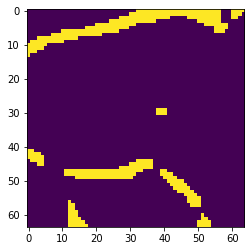

In [72]:
imshow(y_pred_t[24, :, :, 0])

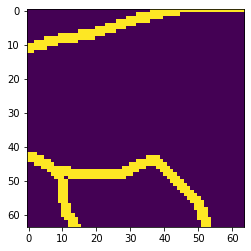

In [70]:
imshow(y_val[24, :, :, 0])

In [76]:
import rasterio
from rasterio.io import MemoryFile
import numpy as np
with rasterio.open("data/train_val/UK_val_mask.tif") as in_arr:
    in_prof = in_arr.profile.copy()
    in_prof.update({'dtype': 'uint16', 'nodata': 65535})
    print(in_prof)
    data = in_arr.read()
    data_to_evaluate = data
    data = np.zeros((data.shape),dtype = np.uint16)
    in_mf = MemoryFile().open(**in_prof)
    in_mf.write(data)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535, 'width': 500, 'height': 100, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'), 'transform': Affine(2.0, 0.0, 3217732.570636626,
       0.0, -2.0, 3126210.942872643), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [77]:
merged_raster = np.zeros((data.shape[0], 2, data.shape[1], data.shape[2]))

In [78]:
merged_raster.shape

(1, 2, 100, 500)

In [79]:
import rasterio
from rasterio.io import MemoryFile
import rasterio.merge
import os
import numpy as np
import glob
count = 0
files=sorted(glob.glob(f'data/val_patches/tile_labels_*.tif'))
for filename in files:
    print(filename)
    with rasterio.open(filename) as src:
        profile = src.profile.copy()
        profile.update({'dtype': 'uint16', 'nodata': 65535})
        print(profile)
        dst = MemoryFile().open(**profile)
        dst.write(y_pred_t[count, :, :, 0].reshape(1,64,64).astype(np.uint16))
        in_merged, _ = rasterio.merge.merge([dst, in_mf], precision=0)
        print(in_merged.shape)
        if in_merged.shape[1] != 100:
            in_merged = in_merged[:, :100, :]
        pred_value = in_merged[0]
        count +=1
        for k in range(2):
            cond = pred_value == k
            merged_raster[0, k, cond] += 1

data/val_patches/tile_labels_UK-0.tif
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535, 'width': 64, 'height': 64, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'), 'transform': Affine(2.0, 0.0, 3217732.570707773,
       0.0, -2.0, 3126210.943205277), 'tiled': False, 'interleave': 'band'}
(1, 101, 500)
data/val_patches/tile_labels_UK-1.tif
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535, 'width': 64, 'height': 64, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Gree

(1, 101, 500)
data/val_patches/tile_labels_UK-27.tif
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535, 'width': 64, 'height': 64, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'), 'transform': Affine(2.0, 0.0, 3218564.570707773,
       0.0, -2.0, 3126146.943205277), 'tiled': False, 'interleave': 'band'}
(1, 100, 500)
data/val_patches/tile_labels_UK-3.tif
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535, 'width': 64, 'height': 64, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0

In [80]:
pred_mask = merged_raster[0,1,:,:]>0

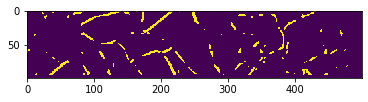

In [81]:
imshow(pred_mask[:,:])